<div align="center">

<p align="center"> 
    <img
        src="./Assets/Turkaracter Logo.png"
        raw=true
        alt="turkaracter_Logo"
        style="width: 128px; height: 128px" />
</p>

# TurKaracter: Entwicklung eines Erkennungssystems von türkischen Handschriften unter Verwendung von künstlichen neuronalen Netzwerken
### Bachelor Abschlussarbeit von Abdurrahman ODABAŞI
### Betreuer: Dr. Ahmet YILDIZ (Türkisch-Deutsche Universität)
### Industriepartner: BIS Çözüm Bilgisayar ve Entegrasyon Hiz. ve Tic. A.Ş.
#### Bearbeitungszeitraum 04.11.2021 - 20.06.2022

</div>

## 0. Imports & Setup

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
import time
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle


# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 0.1. Helper Functions

#### 0.1.1. Save the Figures

In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### 0.1.2. Label to Actual Value (Decoding)

In [4]:
def decodeLabel(value):
    if value <= 9:
        return(chr(value+48))
    elif value > 9 and value < 36:
        return(chr(value+55))
    elif value > 35 and value < 62:
        return(chr(value+61))
    elif value > 61 and value < 72:
        turkishDecoder = {
            62:286 , #Ğ
            63:304 , #İ
            64:214 , #Ö
            65:220 , #Ü
            66:231 , #ç
            67:287 , #ğ
            68:305 , #ı
            69:246 , #ö
            70:351 , #ş
            71:252  #ü
        }
        return (chr(turkishDecoder.get(value)))
    elif value > 71:
        # Labels for punctuation marks
        return 0

#### 0.1.3. Display the Image in the notebook instead of independent window (With the help of Matplotlib)

In [5]:
def displayImage(image): #Gray_Image with one Channel
    dpi = 80
    height, width = image.shape
    # What Size does the figure need to be in inches to fit the image
    figSize = width/float(dpi), height/float(dpi)

    fig = plt.figure(figsize=figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')

    ax.imshow(image, cmap="gray")
    plt.show()

def displayColouredImage(image):
    dpi = 80
    rgb_image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    height, width, depth = rgb_image.shape
    # What Size does the figure need to be in inches to fit the image
    figSize = width/float(dpi), height/float(dpi)

    fig = plt.figure(figsize=figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')

    ax.imshow(rgb_image, cmap="gray")
    plt.show()

## Models

### 0. Baseline Model

In [6]:
baseline_model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

### 1. Picking the dataset with the best performance on the baseline Model

#### 1.1. Model for Combination of (Original NIST19 + Original T-H-E)

In [8]:
X_train = np.load("./SplittedDatasets/1/X_train_1.npy")
y_train = np.load("./SplittedDatasets/1/y_train_1.npy")
# X_test = np.load("./SplittedDatasets/1/X_test_1.npy")
# y_test = np.load("./SplittedDatasets/1/y_test_1.npy")

In [9]:
baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [10]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [11]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Model_Checkpoints/baseline_model_1_1.h5", save_best_only=True)

In [12]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_1"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [14]:
model_1_1_t0 = time.time()
history_1_1 = baseline_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_1_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 368s 22ms/step - loss: 0.5093 - sparse_categorical_accuracy: 0.8324 - sparse_top_k_categorical_accuracy: 0.9699 - val_loss: 0.4495 - val_sparse_categorical_accuracy: 0.8500 - val_sparse_top_k_categorical_accuracy: 0.9793
Epoch 2/100
16688/16688 [==============================] - 364s 22ms/step - loss: 0.4220 - sparse_categorical_accuracy: 0.8567 - sparse_top_k_categorical_accuracy: 0.9824 - val_loss: 0.4284 - val_sparse_categorical_accuracy: 0.8565 - val_sparse_top_k_categorical_accuracy: 0.9822
Epoch 3/100
16688/16688 [==============================] - 371s 22ms/step - loss: 0.3943 - sparse_categorical_accuracy: 0.8642 - sparse_top_k_categorical_accuracy: 0.9850 - val_loss: 0.4199 - val_sparse_categorical_accuracy: 0.8575 - val_sparse_top_k_categorical_accuracy: 0.9820
Epoch 4/100
16688/16688 [==============================] - 377s 23ms/step - loss: 0.3767 - sparse_categorical_accuracy: 0.8692 - sparse_top_k_categorical_accura

In [15]:
print("Training took {:.2f}s for all Epochs".format(model_1_1_t1 - model_1_1_t0))

Training took 7794.09s for all Epochs


In [16]:
history_1_1.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [17]:
print("Best Training Accuracy: ", round(history_1_1.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_1.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_1.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_1.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_1.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_1.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.87559
Best Training Loss:  0.35253
Best Training Top k Accuracy:  0.98858
Best Validation Accuracy:  0.86513
Best Validation Loss:  0.39654
Best Validation Top k Accuracy:  0.98502


In [18]:
baseline_model.save("./Models/baseline_model_1_1")

INFO:tensorflow:Assets written to: ./Models/baseline_model_1_1\assets


Saving figure model_1_1_learning_curves_plot_loss


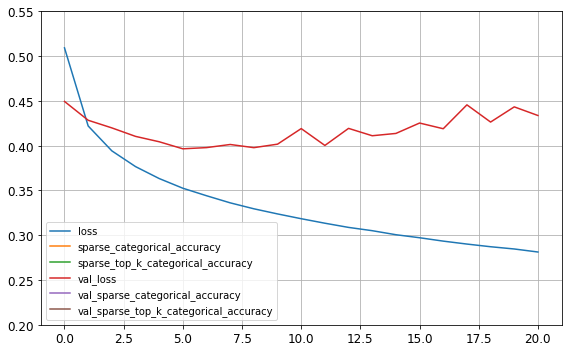

Saving figure model_1_1_learning_curves_plot_accuracy


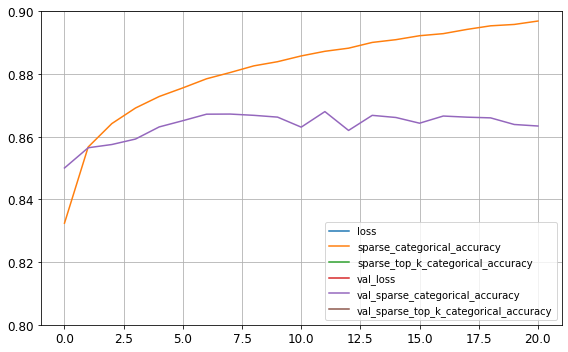

In [210]:
pd.DataFrame(history_1_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.2, 0.55)
save_fig("model_1_1_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 0.9)
save_fig("model_1_1_learning_curves_plot_accuracy")
plt.show()

#### 1.2. Model for Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E)

In [20]:
X_train = np.load("./SplittedDatasets/2/X_train_2.npy")
y_train = np.load("./SplittedDatasets/2/y_train_2.npy")

In [21]:
baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [22]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [23]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Model_Checkpoints/baseline_model_1_2.h5", save_best_only=True)

In [24]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_2"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [25]:
model_1_2_t0 = time.time()
history_1_2 = baseline_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_2_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 366s 22ms/step - loss: 0.4165 - sparse_categorical_accuracy: 0.9042 - sparse_top_k_categorical_accuracy: 0.9865 - val_loss: 0.2105 - val_sparse_categorical_accuracy: 0.9251 - val_sparse_top_k_categorical_accuracy: 0.9931
Epoch 2/100
16688/16688 [==============================] - 368s 22ms/step - loss: 0.1854 - sparse_categorical_accuracy: 0.9338 - sparse_top_k_categorical_accuracy: 0.9952 - val_loss: 0.1855 - val_sparse_categorical_accuracy: 0.9334 - val_sparse_top_k_categorical_accuracy: 0.9949
Epoch 3/100
16688/16688 [==============================] - 367s 22ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.9392 - sparse_top_k_categorical_accuracy: 0.9963 - val_loss: 0.2017 - val_sparse_categorical_accuracy: 0.9269 - val_sparse_top_k_categorical_accuracy: 0.9943
Epoch 4/100
16688/16688 [==============================] - 366s 22ms/step - loss: 0.1547 - sparse_categorical_accuracy: 0.9421 - sparse_top_k_categorical_accura

In [26]:
print("Training took {:.2f}s for all Epochs".format(model_1_2_t1 - model_1_2_t0))

Training took 8043.15s for all Epochs


In [27]:
history_1_2.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [28]:
print("Best Training Accuracy: ", round(history_1_2.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_2.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_2.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_2.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_2.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_2.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.94904
Best Training Loss:  0.13204
Best Training Top k Accuracy:  0.99817
Best Validation Accuracy:  0.93885
Best Validation Loss:  0.17279
Best Validation Top k Accuracy:  0.99557


In [29]:
baseline_model.save("./Models/baseline_model_1_2")

INFO:tensorflow:Assets written to: ./Models/baseline_model_1_2\assets


Saving figure model_1_2_learning_curves_plot_loss


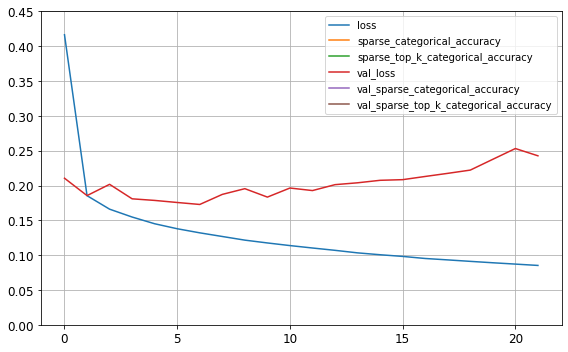

Saving figure model_1_2_learning_curves_plot_accuracy


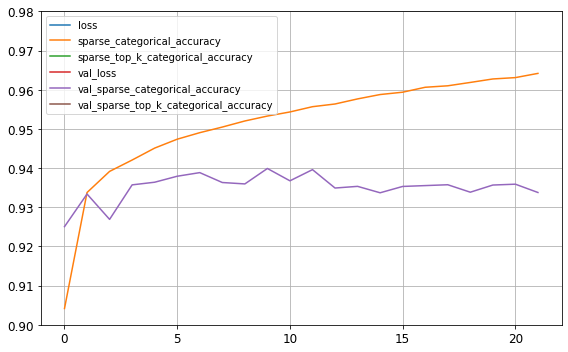

In [211]:
pd.DataFrame(history_1_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.0, 0.45)
save_fig("model_1_2_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.9, 0.98)
save_fig("model_1_2_learning_curves_plot_accuracy")
plt.show()

#### 1.3. Model for Combination of (Zoomed NIST19 (Keras) + Original T-H-E)

In [31]:
X_train = np.load("./SplittedDatasets/3/X_train_3.npy")
y_train = np.load("./SplittedDatasets/3/y_train_3.npy")

In [32]:
baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [33]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [34]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Model_Checkpoints/baseline_model_1_3.h5", save_best_only=True)

In [35]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_3"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [36]:
model_1_3_t0 = time.time()
history_1_3 = baseline_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_3_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 361s 22ms/step - loss: 1.1823 - sparse_categorical_accuracy: 0.5927 - sparse_top_k_categorical_accuracy: 0.8811 - val_loss: 0.9318 - val_sparse_categorical_accuracy: 0.6429 - val_sparse_top_k_categorical_accuracy: 0.9268
Epoch 2/100
16688/16688 [==============================] - 365s 22ms/step - loss: 0.8811 - sparse_categorical_accuracy: 0.6568 - sparse_top_k_categorical_accuracy: 0.9349 - val_loss: 0.8581 - val_sparse_categorical_accuracy: 0.6635 - val_sparse_top_k_categorical_accuracy: 0.9391
Epoch 3/100
16688/16688 [==============================] - 366s 22ms/step - loss: 0.8306 - sparse_categorical_accuracy: 0.6708 - sparse_top_k_categorical_accuracy: 0.9422 - val_loss: 0.8337 - val_sparse_categorical_accuracy: 0.6699 - val_sparse_top_k_categorical_accuracy: 0.9423
Epoch 4/100
16688/16688 [==============================] - 356s 21ms/step - loss: 0.8028 - sparse_categorical_accuracy: 0.6789 - sparse_top_k_categorical_accura

In [37]:
print("Training took {:.2f}s for all Epochs".format(model_1_3_t1 - model_1_3_t0))

Training took 10533.92s for all Epochs


In [38]:
history_1_3.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [39]:
print("Best Training Accuracy: ", round(history_1_3.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_3.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_3.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_3.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_3.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_3.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.70698
Best Training Loss:  0.7086
Best Training Top k Accuracy:  0.95774
Best Validation Accuracy:  0.68612
Best Validation Loss:  0.77851
Best Validation Top k Accuracy:  0.94986


In [40]:
baseline_model.save("./Models/baseline_model_1_3")

INFO:tensorflow:Assets written to: ./Models/baseline_model_1_3\assets


Saving figure model_1_3_learning_curves_plot


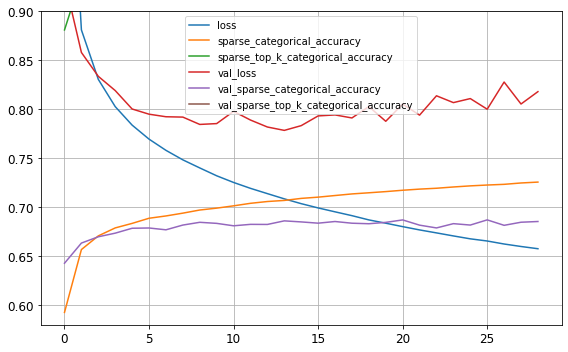

In [220]:
pd.DataFrame(history_1_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.58, 0.90)
save_fig("model_1_3_learning_curves_plot")
plt.show()

#### 1.4. Model for Combination of (Original NIST19 + Padded T-H-E)

In [42]:
X_train = np.load("./SplittedDatasets/4/X_train_4.npy")
y_train = np.load("./SplittedDatasets/4/y_train_4.npy")

In [43]:
baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [44]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [45]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Model_Checkpoints/baseline_model_1_4.h5", save_best_only=True)

In [46]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_4"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [47]:
model_1_4_t0 = time.time()
history_1_4 = baseline_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_4_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 370s 22ms/step - loss: 0.7166 - sparse_categorical_accuracy: 0.7986 - sparse_top_k_categorical_accuracy: 0.9376 - val_loss: 0.4884 - val_sparse_categorical_accuracy: 0.8413 - val_sparse_top_k_categorical_accuracy: 0.9737
Epoch 2/100
16688/16688 [==============================] - 371s 22ms/step - loss: 0.4492 - sparse_categorical_accuracy: 0.8522 - sparse_top_k_categorical_accuracy: 0.9780 - val_loss: 0.4462 - val_sparse_categorical_accuracy: 0.8539 - val_sparse_top_k_categorical_accuracy: 0.9789
Epoch 3/100
16688/16688 [==============================] - 372s 22ms/step - loss: 0.4158 - sparse_categorical_accuracy: 0.8601 - sparse_top_k_categorical_accuracy: 0.9818 - val_loss: 0.4229 - val_sparse_categorical_accuracy: 0.8568 - val_sparse_top_k_categorical_accuracy: 0.9812
Epoch 4/100
16688/16688 [==============================] - 371s 22ms/step - loss: 0.3981 - sparse_categorical_accuracy: 0.8649 - sparse_top_k_categorical_accura

In [48]:
print("Training took {:.2f}s for all Epochs".format(model_1_4_t1 - model_1_4_t0))

Training took 9313.18s for all Epochs


In [49]:
history_1_4.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [50]:
print("Best Training Accuracy: ", round(history_1_4.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_4.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_4.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_4.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_4.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_4.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.8765
Best Training Loss:  0.35377
Best Training Top k Accuracy:  0.98801
Best Validation Accuracy:  0.86666
Best Validation Loss:  0.39471
Best Validation Top k Accuracy:  0.9845


In [51]:
baseline_model.save("./Models/baseline_model_1_4")

INFO:tensorflow:Assets written to: ./Models/baseline_model_1_4\assets


Saving figure model_1_4_learning_curves_plot_loss


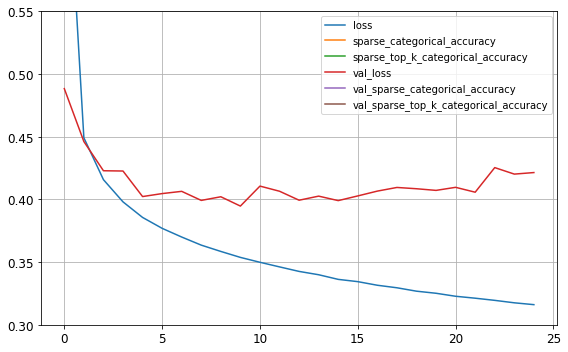

Saving figure model_1_4_learning_curves_plot_accuracy


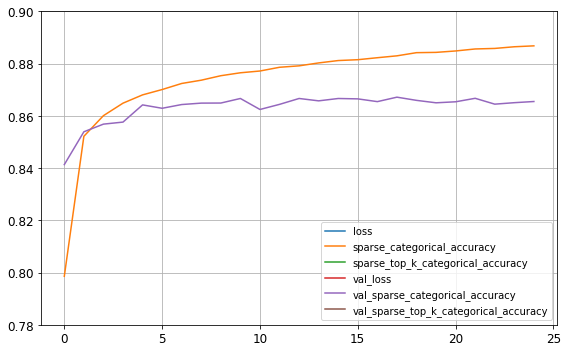

In [222]:
pd.DataFrame(history_1_4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.3, 0.55)
save_fig("model_1_4_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.78, 0.90)
save_fig("model_1_4_learning_curves_plot_accuracy")
plt.show()

#### 1.5. Model for Combination of (Cropped And Resized NIST19 (OpenCV) + Padded T-H-E)

In [53]:
X_train = np.load("./SplittedDatasets/5/X_train_5.npy")
y_train = np.load("./SplittedDatasets/5/y_train_5.npy")

In [54]:
baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [55]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [56]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Model_Checkpoints/baseline_model_1_5.h5", save_best_only=True)

In [57]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_5"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [58]:
model_1_5_t0 = time.time()
history_1_5 = baseline_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_5_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 374s 22ms/step - loss: 0.5679 - sparse_categorical_accuracy: 0.8907 - sparse_top_k_categorical_accuracy: 0.9822 - val_loss: 0.2288 - val_sparse_categorical_accuracy: 0.9215 - val_sparse_top_k_categorical_accuracy: 0.9919
Epoch 2/100
16688/16688 [==============================] - 375s 22ms/step - loss: 0.2040 - sparse_categorical_accuracy: 0.9292 - sparse_top_k_categorical_accuracy: 0.9938 - val_loss: 0.1981 - val_sparse_categorical_accuracy: 0.9305 - val_sparse_top_k_categorical_accuracy: 0.9941
Epoch 3/100
16688/16688 [==============================] - 373s 22ms/step - loss: 0.1824 - sparse_categorical_accuracy: 0.9352 - sparse_top_k_categorical_accuracy: 0.9951 - val_loss: 0.1921 - val_sparse_categorical_accuracy: 0.9332 - val_sparse_top_k_categorical_accuracy: 0.9945
Epoch 4/100
16688/16688 [==============================] - 373s 22ms/step - loss: 0.1705 - sparse_categorical_accuracy: 0.9387 - sparse_top_k_categorical_accura

In [59]:
print("Training took {:.2f}s for all Epochs".format(model_1_5_t1 - model_1_5_t0))

Training took 8016.11s for all Epochs


In [60]:
history_1_5.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [61]:
print("Best Training Accuracy: ", round(history_1_5.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_5.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_5.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_5.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_5.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_5.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.94435
Best Training Loss:  0.15003
Best Training Top k Accuracy:  0.99713
Best Validation Accuracy:  0.93719
Best Validation Loss:  0.17586
Best Validation Top k Accuracy:  0.99557


In [62]:
baseline_model.save("./Models/baseline_model_1_5")

INFO:tensorflow:Assets written to: ./Models/baseline_model_1_5\assets


Saving figure model_1_5_learning_curves_plot_loss


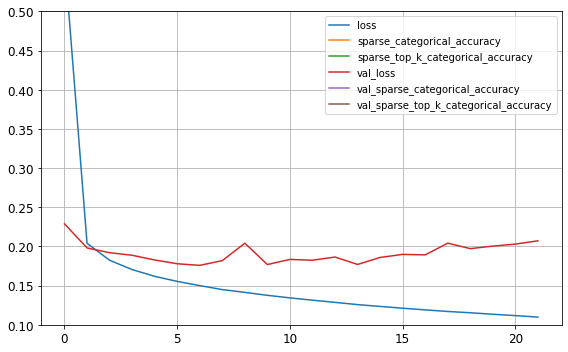

Saving figure model_1_5_learning_curves_plot_accuracy


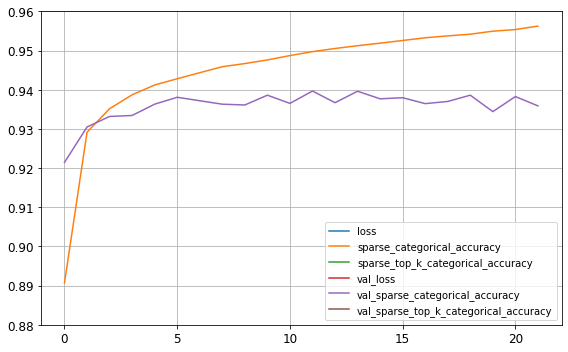

In [225]:
pd.DataFrame(history_1_5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.1, 0.5)
save_fig("model_1_5_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.88, 0.96)
save_fig("model_1_5_learning_curves_plot_accuracy")
plt.show()

#### 1.6. Model for Combination of (Zoomed NIST19 (Keras) + Padded T-H-E)

In [64]:
X_train = np.load("./SplittedDatasets/6/X_train_6.npy")
y_train = np.load("./SplittedDatasets/6/y_train_6.npy")

In [65]:
baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [66]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [67]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Model_Checkpoints/baseline_model_1_6.h5", save_best_only=True)

In [68]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_6"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [69]:
model_1_6_t0 = time.time()
history_1_6 = baseline_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_6_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 350s 21ms/step - loss: 1.3896 - sparse_categorical_accuracy: 0.5552 - sparse_top_k_categorical_accuracy: 0.8406 - val_loss: 1.0130 - val_sparse_categorical_accuracy: 0.6272 - val_sparse_top_k_categorical_accuracy: 0.9131
Epoch 2/100
16688/16688 [==============================] - 351s 21ms/step - loss: 0.9472 - sparse_categorical_accuracy: 0.6407 - sparse_top_k_categorical_accuracy: 0.9240 - val_loss: 0.9119 - val_sparse_categorical_accuracy: 0.6527 - val_sparse_top_k_categorical_accuracy: 0.9307
Epoch 3/100
16688/16688 [==============================] - 351s 21ms/step - loss: 0.8678 - sparse_categorical_accuracy: 0.6605 - sparse_top_k_categorical_accuracy: 0.9364 - val_loss: 0.8615 - val_sparse_categorical_accuracy: 0.6624 - val_sparse_top_k_categorical_accuracy: 0.9371
Epoch 4/100
16688/16688 [==============================] - 364s 22ms/step - loss: 0.8285 - sparse_categorical_accuracy: 0.6712 - sparse_top_k_categorical_accura

In [70]:
print("Training took {:.2f}s for all Epochs".format(model_1_6_t1 - model_1_6_t0))

Training took 9839.85s for all Epochs


In [71]:
history_1_6.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [72]:
print("Best Training Accuracy: ", round(history_1_6.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_6.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_6.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_6.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_6.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_6.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.6987
Best Training Loss:  0.73688
Best Training Top k Accuracy:  0.95414
Best Validation Accuracy:  0.68381
Best Validation Loss:  0.79116
Best Validation Top k Accuracy:  0.94733


In [73]:
baseline_model.save("./Models/baseline_model_1_6")

INFO:tensorflow:Assets written to: ./Models/baseline_model_1_6\assets


Saving figure model_1_6_learning_curves_plot


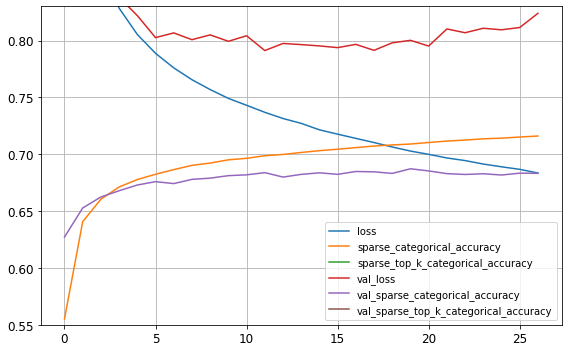

In [229]:
pd.DataFrame(history_1_6.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.55, 0.83)
save_fig("model_1_6_learning_curves_plot")
plt.show()

#### 1.7. Model for Combination of (Original NIST19 + Original T-H-E + Padded T-H-E)

In [75]:
X_train = np.load("./SplittedDatasets/7/X_train_7.npy")
y_train = np.load("./SplittedDatasets/7/y_train_7.npy")

In [76]:
baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [77]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [78]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Model_Checkpoints/baseline_model_1_7.h5", save_best_only=True)

In [79]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_7"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [80]:
model_1_7_t0 = time.time()
history_1_7 = baseline_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_7_t1 = time.time()

Epoch 1/100
16913/16913 [==============================] - 371s 22ms/step - loss: 0.6934 - sparse_categorical_accuracy: 0.7988 - sparse_top_k_categorical_accuracy: 0.9402 - val_loss: 0.4949 - val_sparse_categorical_accuracy: 0.8357 - val_sparse_top_k_categorical_accuracy: 0.9745
Epoch 2/100
16913/16913 [==============================] - 371s 22ms/step - loss: 0.4464 - sparse_categorical_accuracy: 0.8518 - sparse_top_k_categorical_accuracy: 0.9787 - val_loss: 0.4474 - val_sparse_categorical_accuracy: 0.8533 - val_sparse_top_k_categorical_accuracy: 0.9795
Epoch 3/100
16913/16913 [==============================] - 372s 22ms/step - loss: 0.4134 - sparse_categorical_accuracy: 0.8598 - sparse_top_k_categorical_accuracy: 0.9821 - val_loss: 0.4170 - val_sparse_categorical_accuracy: 0.8591 - val_sparse_top_k_categorical_accuracy: 0.9818
Epoch 4/100
16913/16913 [==============================] - 398s 24ms/step - loss: 0.3967 - sparse_categorical_accuracy: 0.8651 - sparse_top_k_categorical_accura

In [81]:
print("Training took {:.2f}s for all Epochs".format(model_1_7_t1 - model_1_7_t0))

Training took 11307.68s for all Epochs


In [82]:
history_1_7.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [83]:
print("Best Training Accuracy: ", round(history_1_7.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_7.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_7.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_7.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_7.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_7.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.87871
Best Training Loss:  0.34334
Best Training Top k Accuracy:  0.98891
Best Validation Accuracy:  0.86569
Best Validation Loss:  0.39288
Best Validation Top k Accuracy:  0.98501


In [84]:
baseline_model.save("./Models/baseline_model_1_7")

INFO:tensorflow:Assets written to: ./Models/baseline_model_1_7\assets


Saving figure model_1_7_learning_curves_plot_loss


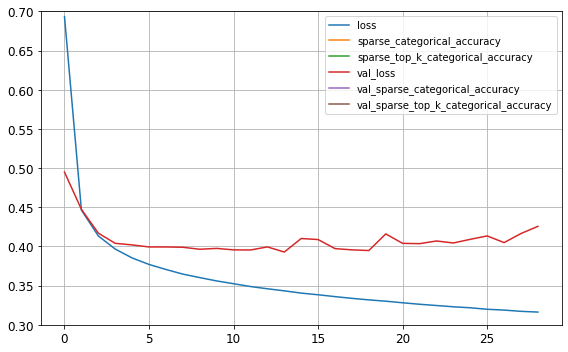

Saving figure model_1_7_learning_curves_plot_accuracy


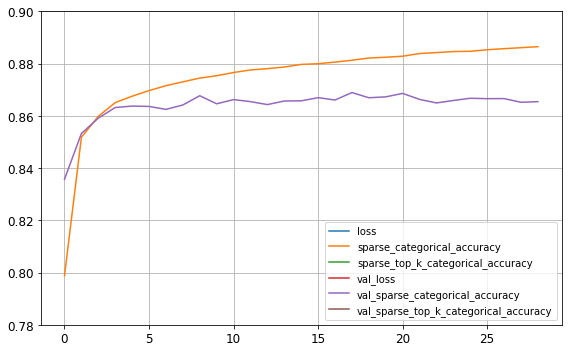

In [236]:
pd.DataFrame(history_1_7.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.3, 0.7)
save_fig("model_1_7_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_7.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.78, 0.9)
save_fig("model_1_7_learning_curves_plot_accuracy")
plt.show()

#### 1.8. Model for Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E + Padded T-H-E)

In [86]:
X_train = np.load("./SplittedDatasets/8/X_train_8.npy")
y_train = np.load("./SplittedDatasets/8/y_train_8.npy")

In [87]:
baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [88]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [89]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Model_Checkpoints/baseline_model_1_8.h5", save_best_only=True)

In [90]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_8"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [91]:
model_1_8_t0 = time.time()
history_1_8 = baseline_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_8_t1 = time.time()

Epoch 1/100
16913/16913 [==============================] - 386s 23ms/step - loss: 0.5315 - sparse_categorical_accuracy: 0.8830 - sparse_top_k_categorical_accuracy: 0.9732 - val_loss: 0.2379 - val_sparse_categorical_accuracy: 0.9172 - val_sparse_top_k_categorical_accuracy: 0.9856
Epoch 2/100
16913/16913 [==============================] - 386s 23ms/step - loss: 0.2289 - sparse_categorical_accuracy: 0.9203 - sparse_top_k_categorical_accuracy: 0.9871 - val_loss: 0.2167 - val_sparse_categorical_accuracy: 0.9222 - val_sparse_top_k_categorical_accuracy: 0.9876
Epoch 3/100
16913/16913 [==============================] - 386s 23ms/step - loss: 0.2057 - sparse_categorical_accuracy: 0.9269 - sparse_top_k_categorical_accuracy: 0.9904 - val_loss: 0.2031 - val_sparse_categorical_accuracy: 0.9279 - val_sparse_top_k_categorical_accuracy: 0.9936
Epoch 4/100
16913/16913 [==============================] - 387s 23ms/step - loss: 0.1862 - sparse_categorical_accuracy: 0.9331 - sparse_top_k_categorical_accura

In [92]:
print("Training took {:.2f}s for all Epochs".format(model_1_8_t1 - model_1_8_t0))

Training took 10529.01s for all Epochs


In [93]:
history_1_8.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [94]:
print("Best Training Accuracy: ", round(history_1_8.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_8.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_8.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_8.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_8.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_8.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.94508
Best Training Loss:  0.14517
Best Training Top k Accuracy:  0.99739
Best Validation Accuracy:  0.93782
Best Validation Loss:  0.17868
Best Validation Top k Accuracy:  0.99545


In [95]:
baseline_model.save("./Models/baseline_model_1_8")

INFO:tensorflow:Assets written to: ./Models/baseline_model_1_8\assets


Saving figure model_1_8_learning_curves_plot_loss


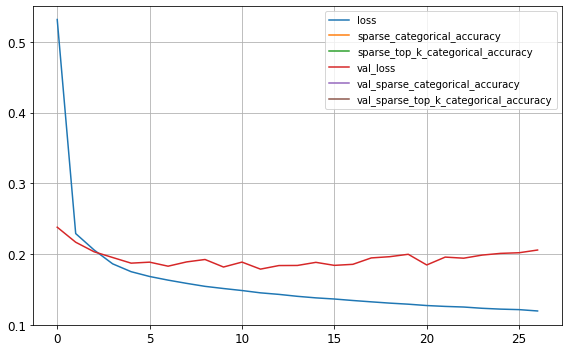

Saving figure model_1_8_learning_curves_plot_accuracy


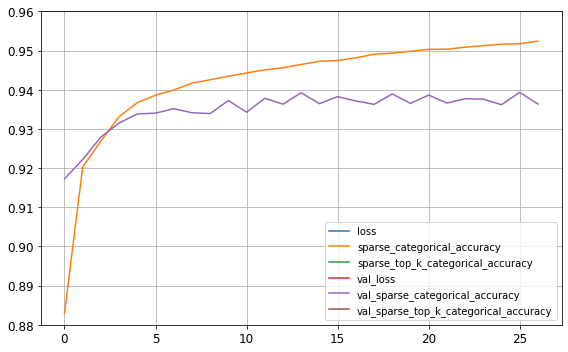

In [237]:
pd.DataFrame(history_1_8.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.1, 0.55)
save_fig("model_1_8_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_8.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.88, 0.96)
save_fig("model_1_8_learning_curves_plot_accuracy")
plt.show()

#### 1.9. Model for Combination of (Zoomed NIST19 (Keras) + Original T-H-E + Padded T-H-E)

In [97]:
X_train = np.load("./SplittedDatasets/9/X_train_9.npy")
y_train = np.load("./SplittedDatasets/9/y_train_9.npy")

In [98]:
baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [99]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [100]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Model_Checkpoints/baseline_model_1_9.h5", save_best_only=True)

In [101]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_9"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [102]:
model_1_9_t0 = time.time()
history_1_9 = baseline_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_9_t1 = time.time()

Epoch 1/100
16913/16913 [==============================] - 397s 23ms/step - loss: 1.4039 - sparse_categorical_accuracy: 0.5534 - sparse_top_k_categorical_accuracy: 0.8381 - val_loss: 1.0264 - val_sparse_categorical_accuracy: 0.6237 - val_sparse_top_k_categorical_accuracy: 0.9112
Epoch 2/100
16913/16913 [==============================] - 395s 23ms/step - loss: 0.9515 - sparse_categorical_accuracy: 0.6420 - sparse_top_k_categorical_accuracy: 0.9223 - val_loss: 0.9277 - val_sparse_categorical_accuracy: 0.6483 - val_sparse_top_k_categorical_accuracy: 0.9276
Epoch 3/100
16913/16913 [==============================] - 395s 23ms/step - loss: 0.8774 - sparse_categorical_accuracy: 0.6602 - sparse_top_k_categorical_accuracy: 0.9337 - val_loss: 0.8677 - val_sparse_categorical_accuracy: 0.6601 - val_sparse_top_k_categorical_accuracy: 0.9350
Epoch 4/100
16913/16913 [==============================] - 396s 23ms/step - loss: 0.8414 - sparse_categorical_accuracy: 0.6696 - sparse_top_k_categorical_accura

In [103]:
print("Training took {:.2f}s for all Epochs".format(model_1_9_t1 - model_1_9_t0))

Training took 15002.15s for all Epochs


In [104]:
history_1_9.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [115]:
print("Best Training Accuracy: ", round(history_1_9.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_9.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_9.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_9.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_9.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_9.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.70866
Best Training Loss:  0.7057
Best Training Top k Accuracy:  0.95716
Best Validation Accuracy:  0.68617
Best Validation Loss:  0.79914
Best Validation Loss:  0.8
Best Validation Loss:  0.80071
Best Validation Loss:  0.79011
Best Validation Loss:  0.80319
Best Validation Top k Accuracy:  0.94912


In [ ]:
baseline_model.save("./Models/baseline_model_1_9")

INFO:tensorflow:Assets written to: ./Models/baseline_model_1_9\assets


Saving figure model_1_9_learning_curves_plot


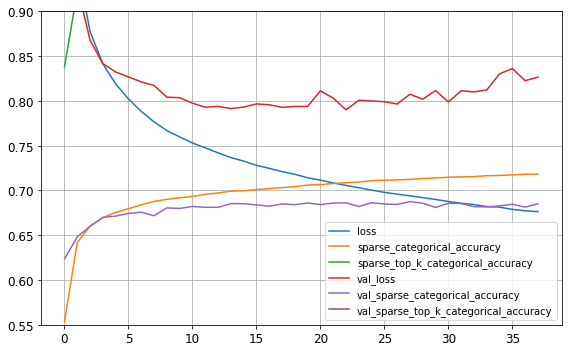

In [240]:
pd.DataFrame(history_1_9.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.55, 0.9)
save_fig("model_1_9_learning_curves_plot")
plt.show()

#### 1.10. Comparison between Combinations

In [184]:
combinations = [
    "Original NIST19 + Original T-H-E",
    "Cropped & Resized NIST19 (OpenCV) + Original T-H-E",
    "Zoomed NIST19 (Keras) + Original T-H-E",
    "Original NIST19 + Padded T-H-E",
    "Cropped & Resized NIST19 (OpenCV) + Padded T-H-E",
    "Zoomed NIST19 (Keras) + Padded T-H-E",
    "Original NIST19 + Original T-H-E + Padded T-H-E",
    "Cropped & Resized NIST19 (OpenCV) + Original T-H-E + Padded T-H-E",
    "Zoomed NIST19 (Keras) + Original T-H-E + Padded T-H-E"
]

In [205]:
val_losses = [
    history_1_1.history['val_loss'][-16],
    history_1_2.history['val_loss'][-16],
    history_1_3.history['val_loss'][-16],
    history_1_4.history['val_loss'][-16],
    history_1_5.history['val_loss'][-16],
    history_1_6.history['val_loss'][-16],
    history_1_7.history['val_loss'][-16],
    history_1_8.history['val_loss'][-16],
    history_1_9.history['val_loss'][-16]
]

val_loss_data = {
    'Combinations': combinations,
    'Validation Losses (Lower is better)': val_losses
}
val_loss_df = pd.DataFrame(val_loss_data)

Saving figure Validation Losses between Combinations


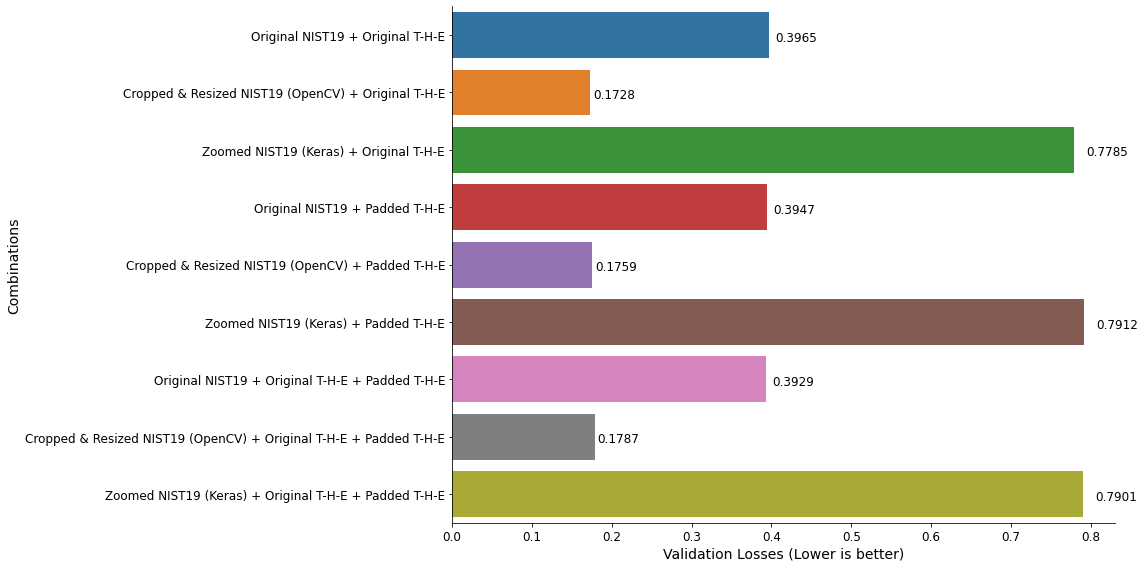

In [206]:
val_loss_catplot = sns.catplot(y="Combinations", x="Validation Losses (Lower is better)", kind="bar", height=8, aspect=2, orient='h',  data=val_loss_df)
val_loss_catplot.set_yticklabels(fontsize=12, rotation=0)
val_loss_catplot.set_xticklabels(fontsize=12, rotation=0)
ax5 = val_loss_catplot.facet_axis(0,0)
for p in ax5.patches:
    ax5.text( p.get_width() * 1.02,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validation Losses between Combinations', tight_layout=True)

In [187]:
val_accuracies = [
    history_1_1.history['val_sparse_categorical_accuracy'][-16],
    history_1_2.history['val_sparse_categorical_accuracy'][-16],
    history_1_3.history['val_sparse_categorical_accuracy'][-16],
    history_1_4.history['val_sparse_categorical_accuracy'][-16],
    history_1_5.history['val_sparse_categorical_accuracy'][-16],
    history_1_6.history['val_sparse_categorical_accuracy'][-16],
    history_1_7.history['val_sparse_categorical_accuracy'][-16],
    history_1_8.history['val_sparse_categorical_accuracy'][-16],
    history_1_9.history['val_sparse_categorical_accuracy'][-16]
]

val_accuracies_data = {
    'Combinations': combinations,
    'Validation Accuracy (Higher is better)': val_accuracies
}
val_accuracies_data_df = pd.DataFrame(val_accuracies_data)

Saving figure Validation Accuracy between Combinations


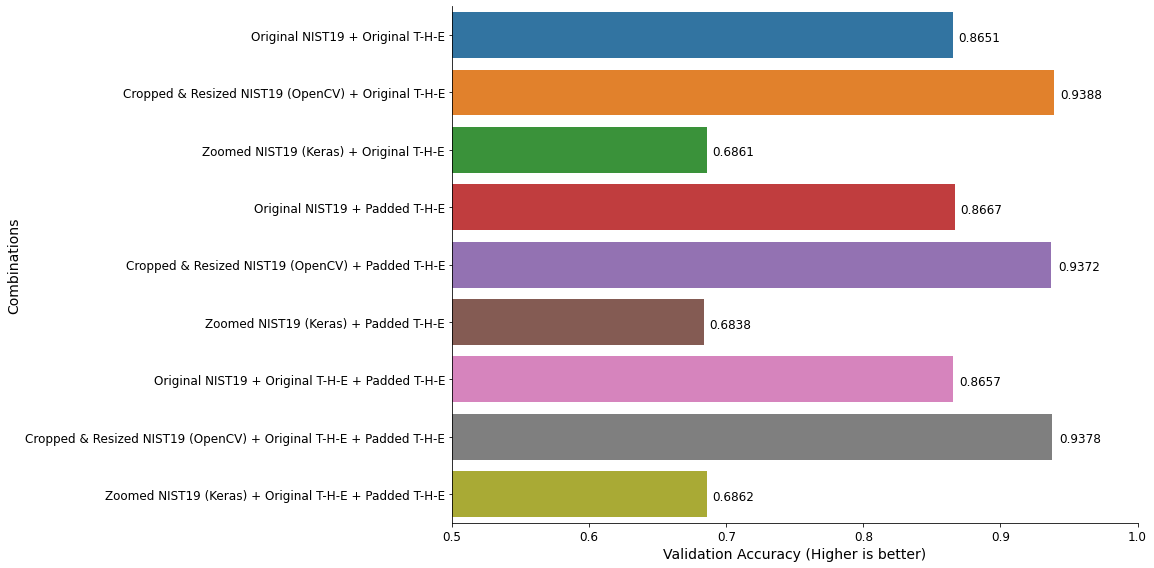

In [188]:
val_accuracies_catplot = sns.catplot(y="Combinations", x="Validation Accuracy (Higher is better)", kind="bar", height=8, aspect=2, orient='h',  data=val_accuracies_data_df)
val_accuracies_catplot.set_yticklabels(fontsize=12, rotation=0)
ax6 = val_accuracies_catplot.facet_axis(0,0)
val_accuracies_catplot.set(xlim=(0.5,1))
for p in ax6.patches:
    ax6.text( p.get_width() * 1.005,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validation Accuracy between Combinations', tight_layout=True)

In [189]:
epoch_train_time = [
    (model_1_1_t1 - model_1_1_t0) / len(history_1_1.history['val_loss']),
    (model_1_2_t1 - model_1_2_t0) / len(history_1_2.history['val_loss']),
    (model_1_3_t1 - model_1_3_t0) / len(history_1_3.history['val_loss']),
    (model_1_4_t1 - model_1_4_t0) / len(history_1_4.history['val_loss']),
    (model_1_5_t1 - model_1_5_t0) / len(history_1_5.history['val_loss']),
    (model_1_6_t1 - model_1_6_t0) / len(history_1_6.history['val_loss']),
    (model_1_7_t1 - model_1_7_t0) / len(history_1_7.history['val_loss']),
    (model_1_8_t1 - model_1_8_t0) / len(history_1_8.history['val_loss']),
    (model_1_9_t1 - model_1_9_t0) / len(history_1_9.history['val_loss'])
]

train_time_data = {
    'Combinations': combinations,
    'Training Time per Epoch (Lower is better)': epoch_train_time
}
train_time_data_df = pd.DataFrame(train_time_data)

Saving figure Training Time Per Epoch between Combinations


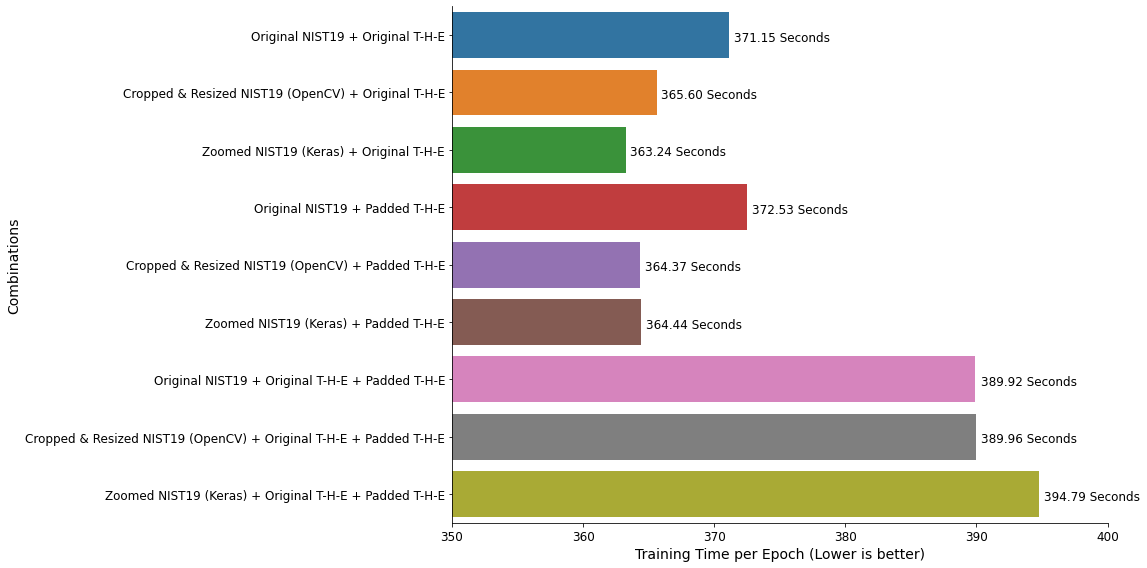

In [196]:
train_time_catplot = sns.catplot(y="Combinations", x="Training Time per Epoch (Lower is better)", kind="bar", height=8, aspect=2, orient='h',  data=train_time_data_df)
train_time_catplot.set_yticklabels(fontsize=12, rotation=0)
ax7 = train_time_catplot.facet_axis(0,0)
train_time_catplot.set(xlim=(350,400))
for p in ax7.patches:
    ax7.text( p.get_width() * 1.001,
            p.get_y() + 0.5,
            '{0:.2f} Seconds'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Training Time Per Epoch between Combinations', tight_layout=True)

In [197]:
combinations_de = [
    "Originaler NIST19 + Originaler T-H-E",
    "Zugeschnitten & reskalierter NIST19 (Mit OpenCV) + Originaler T-H-E",
    "Gezoomter NIST19 (Mit Keras) + Originaler T-H-E",
    "Originaler NIST19 + Wattiert T-H-E",
    "Zugeschnitten & reskalierter NIST19 (Mit OpenCV) + Wattiert T-H-E",
    "Gezoomter NIST19 (Mit Keras) + Wattiert T-H-E",
    "Originaler NIST19 + Originaler T-H-E + Wattiert T-H-E",
    "Zugeschnitten & reskalierter NIST19 (Mit OpenCV) + Originaler T-H-E + Wattiert T-H-E",
    "Gezoomter NIST19 (Mit Keras) + Originaler T-H-E + Wattiert T-H-E"
]

In [198]:
val_losses = [
    history_1_1.history['val_loss'][-16],
    history_1_2.history['val_loss'][-16],
    history_1_3.history['val_loss'][-16],
    history_1_4.history['val_loss'][-16],
    history_1_5.history['val_loss'][-16],
    history_1_6.history['val_loss'][-16],
    history_1_7.history['val_loss'][-16],
    history_1_8.history['val_loss'][-16],
    history_1_9.history['val_loss'][-16]
]

val_loss_data = {
    'Kombinationen': combinations_de,
    'Validierungsverlust (Niedriger ist besser)': val_losses
}
val_loss_df = pd.DataFrame(val_loss_data)

Saving figure Validierungsverluste zwischen Kombinationen


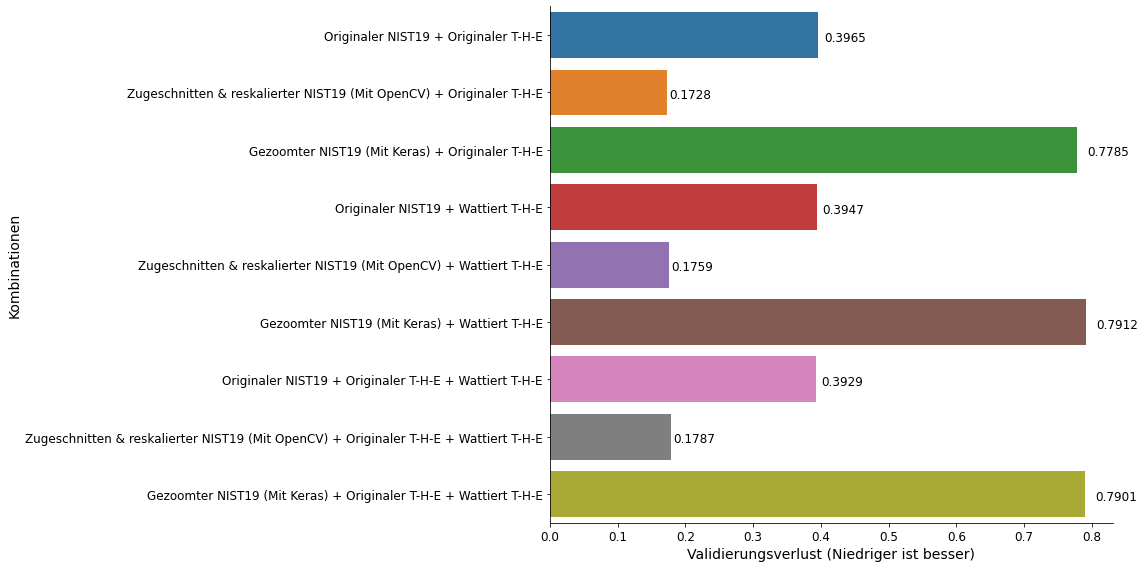

In [199]:
val_loss_catplot = sns.catplot(y="Kombinationen", x="Validierungsverlust (Niedriger ist besser)", kind="bar", height=8, aspect=2, orient='h',  data=val_loss_df)
val_loss_catplot.set_yticklabels(fontsize=12, rotation=0)
val_loss_catplot.set_xticklabels(fontsize=12, rotation=0)
ax5 = val_loss_catplot.facet_axis(0,0)
for p in ax5.patches:
    ax5.text( p.get_width() * 1.02,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validierungsverluste zwischen Kombinationen', tight_layout=True)

In [200]:
val_accuracies = [
    history_1_1.history['val_sparse_categorical_accuracy'][-16],
    history_1_2.history['val_sparse_categorical_accuracy'][-16],
    history_1_3.history['val_sparse_categorical_accuracy'][-16],
    history_1_4.history['val_sparse_categorical_accuracy'][-16],
    history_1_5.history['val_sparse_categorical_accuracy'][-16],
    history_1_6.history['val_sparse_categorical_accuracy'][-16],
    history_1_7.history['val_sparse_categorical_accuracy'][-16],
    history_1_8.history['val_sparse_categorical_accuracy'][-16],
    history_1_9.history['val_sparse_categorical_accuracy'][-16]
]

val_accuracies_data = {
    'Kombinationen': combinations_de,
    'Validierungsgenauigkeit (Höher ist besser)': val_accuracies
}
val_accuracies_data_df = pd.DataFrame(val_accuracies_data)

Saving figure Validierungsgenauigkeit zwischen Kombinationen


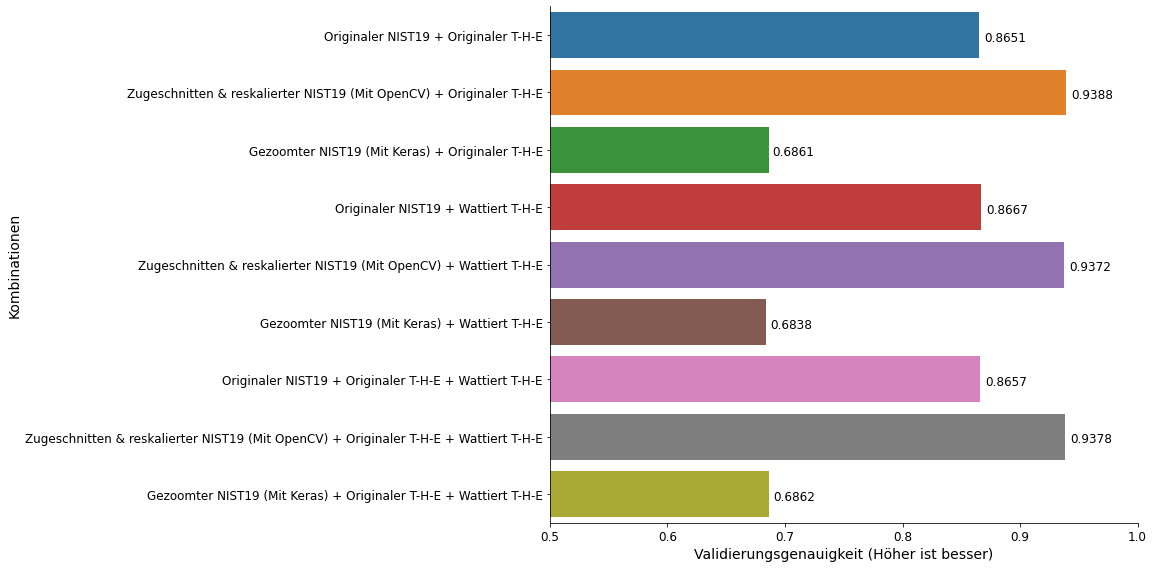

In [201]:
val_accuracies_catplot = sns.catplot(y="Kombinationen", x="Validierungsgenauigkeit (Höher ist besser)", kind="bar", height=8, aspect=2, orient='h',  data=val_accuracies_data_df)
val_accuracies_catplot.set_yticklabels(fontsize=12, rotation=0)
ax6 = val_accuracies_catplot.facet_axis(0,0)
val_accuracies_catplot.set(xlim=(0.5,1))
for p in ax6.patches:
    ax6.text( p.get_width() * 1.005,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validierungsgenauigkeit zwischen Kombinationen', tight_layout=False)

In [202]:
epoch_train_time = [
    (model_1_1_t1 - model_1_1_t0) / len(history_1_1.history['val_loss']),
    (model_1_2_t1 - model_1_2_t0) / len(history_1_2.history['val_loss']),
    (model_1_3_t1 - model_1_3_t0) / len(history_1_3.history['val_loss']),
    (model_1_4_t1 - model_1_4_t0) / len(history_1_4.history['val_loss']),
    (model_1_5_t1 - model_1_5_t0) / len(history_1_5.history['val_loss']),
    (model_1_6_t1 - model_1_6_t0) / len(history_1_6.history['val_loss']),
    (model_1_7_t1 - model_1_7_t0) / len(history_1_7.history['val_loss']),
    (model_1_8_t1 - model_1_8_t0) / len(history_1_8.history['val_loss']),
    (model_1_9_t1 - model_1_9_t0) / len(history_1_9.history['val_loss'])
]

train_time_data = {
    'Kombinationen': combinations_de,
    'Trainingszeit pro Epoche (Niedriger ist besser)': epoch_train_time
}
train_time_data_df = pd.DataFrame(train_time_data)

Saving figure Trainingszeit pro Epoche zwischen Kombinationen


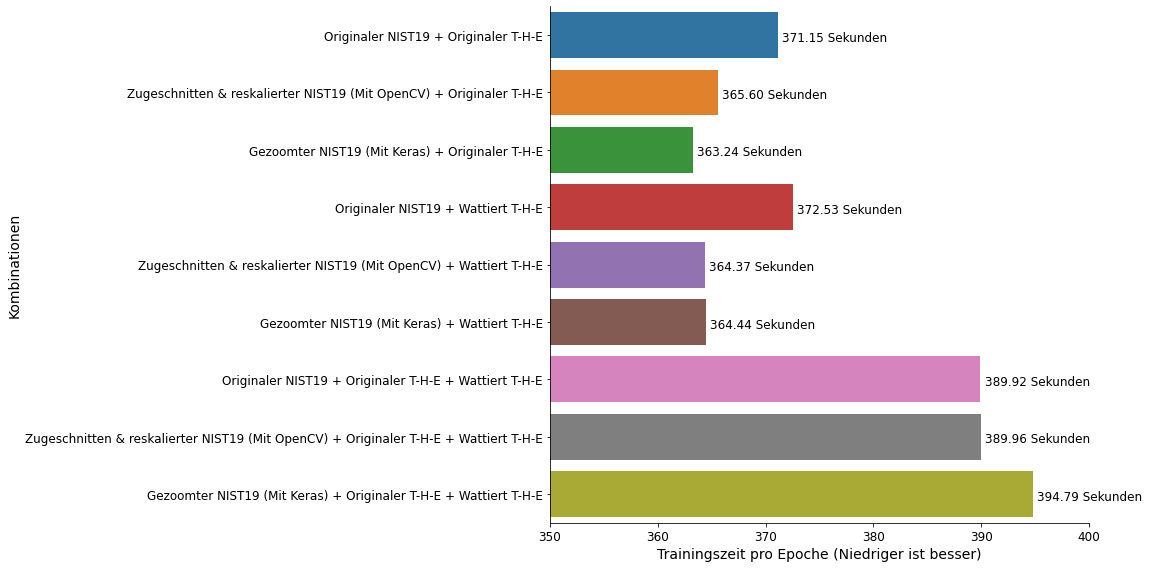

In [204]:
train_time_catplot = sns.catplot(y="Kombinationen", x="Trainingszeit pro Epoche (Niedriger ist besser)", kind="bar", height=8, aspect=2, orient='h',  data=train_time_data_df)
train_time_catplot.set_yticklabels(fontsize=12, rotation=0)
ax7 = train_time_catplot.facet_axis(0,0)
train_time_catplot.set(xlim=(350,400))
for p in ax7.patches:
    ax7.text( p.get_width() * 1.001,
            p.get_y() + 0.5,
            '{0:.2f} Sekunden'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Trainingszeit pro Epoche zwischen Kombinationen', tight_layout=True)

So we can officially say that the combinations 2,5,8 are the best combinations of datasets

But as we have seen, the number of digit datapoints is so higher than the number of any another character whether it is turkish or english.

So Let's train the best 3 models and telling them to "pay more attention" to samples from an under-represented classes. This will be done with the use of the `class_weight` argument of the fit function

#### 1.11 Training the Balanced Model for Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E)

In [241]:
X_train = np.load("./SplittedDatasets/2/X_train_2.npy")
y_train = np.load("./SplittedDatasets/2/y_train_2.npy")

In [247]:
from sklearn.utils import class_weight
y_train_class_weights = y_train.reshape(-1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train_class_weights)

In [248]:
print(class_weights)

[ 0.29596862  0.27072261  0.30132695  0.2918595   0.30810678  0.33156742
  0.30226028  0.28776462  0.30399479  0.3054773   1.46989456  2.5185072
  0.91040214  2.08281847  1.90049713  1.00954209  3.99940682  3.14898947
  0.78160568  2.59972658  4.16657303  1.91304684  1.0273299   1.12589568
  0.3591595   1.11038747  4.01499567  1.89505826  0.43233806  0.94271151
  0.72819299  2.08048137  2.04966283  3.7716131   2.02459598  3.81821458
  0.92006997  1.85560949  3.68906685  0.9018995   0.36399643  4.13129456
  2.68324891  1.06046957  3.69494819  5.38363821  4.02021899  0.608189
  3.91000633  0.80126404  3.7306338   4.28996992  3.30621434  0.64644202
  3.81821458  0.49538447  3.63126714  3.60865123  3.81664265  3.65272853
  4.36675695  3.77930086 10.30069444 10.30069444 10.30069444 10.30069444
 10.30069444 10.30069444 10.30069444 10.30069444 10.30069444 10.30069444]


The problem is that the sklearn API returns a numpy array but the keras requires a dictionary as an input for class_weight

More Information on: https://stackoverflow.com/questions/61261907/on-colab-class-weight-is-causing-a-valueerror-the-truth-value-of-an-array-wit

In [256]:
class_weights = {i : class_weights[i] for i in range(class_weights.shape[0])}

In [257]:
print(class_weights)

{0: 0.29596861730996393, 1: 0.27072260834014716, 2: 0.3013269518299421, 3: 0.2918594950258154, 4: 0.3081067832098109, 5: 0.33156741773962806, 6: 0.30226027843891623, 7: 0.2877646200645642, 8: 0.303994786201469, 9: 0.3054772966917095, 10: 1.4698945615982242, 11: 2.518507199130671, 12: 0.9104021408229402, 13: 2.082818467760054, 14: 1.9004971299712996, 15: 1.009542088642056, 16: 3.9994068162208802, 17: 3.148989470108696, 18: 0.7816056824888289, 19: 2.5997265844083004, 20: 4.1665730337078655, 21: 1.913046842756913, 22: 1.0273298980496455, 23: 1.1258956764634442, 24: 0.3591594994576166, 25: 1.1103874715534794, 26: 4.0149956691208315, 27: 1.8950582583810303, 28: 0.43233805904024625, 29: 0.9427115110839943, 30: 0.7281929934804807, 31: 2.0804813734290843, 32: 2.0496628344019454, 33: 3.771613100081367, 34: 2.0245959816553833, 35: 3.818214579901153, 36: 0.9200699682413657, 37: 1.8556094875900722, 38: 3.689066852367688, 39: 0.9018995038427863, 40: 0.36399642702893714, 41: 4.131294563279857, 42: 2

In [249]:
baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [250]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [251]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_1_11.h5", save_best_only=True)

In [252]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_11"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [258]:
model_1_11_t0 = time.time()
history_1_11 = baseline_model.fit(X_train, y_train, class_weight=class_weights, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_11_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 379s 23ms/step - loss: 0.9886 - sparse_categorical_accuracy: 0.7719 - sparse_top_k_categorical_accuracy: 0.9101 - val_loss: 0.3759 - val_sparse_categorical_accuracy: 0.8785 - val_sparse_top_k_categorical_accuracy: 0.9787
Epoch 2/100
16688/16688 [==============================] - 380s 23ms/step - loss: 0.3935 - sparse_categorical_accuracy: 0.8883 - sparse_top_k_categorical_accuracy: 0.9844 - val_loss: 0.3322 - val_sparse_categorical_accuracy: 0.8870 - val_sparse_top_k_categorical_accuracy: 0.9859
Epoch 3/100
16688/16688 [==============================] - 379s 23ms/step - loss: 0.3357 - sparse_categorical_accuracy: 0.9015 - sparse_top_k_categorical_accuracy: 0.9886 - val_loss: 0.2693 - val_sparse_categorical_accuracy: 0.9068 - val_sparse_top_k_categorical_accuracy: 0.9897
Epoch 4/100
16688/16688 [==============================] - 379s 23ms/step - loss: 0.3110 - sparse_categorical_accuracy: 0.9079 - sparse_top_k_categorical_accura

In [259]:
print("Training took {:.2f}s for all Epochs".format(model_1_11_t1 - model_1_11_t0))

Training took 12787.69s for all Epochs


In [260]:
history_1_11.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [266]:
print("Best Training Accuracy: ", round(history_1_11.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_11.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_11.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_11.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_11.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_11.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.92731
Best Training Loss:  0.22037
Best Training Top k Accuracy:  0.99528
Best Validation Accuracy:  0.92208
Best Validation Loss:  0.22642
Best Validation Top k Accuracy:  0.99272


In [262]:
baseline_model.save("./Model_Checkpoints/baseline_model_1_11")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_11\assets


Saving figure model_1_11_learning_curves_plot_loss


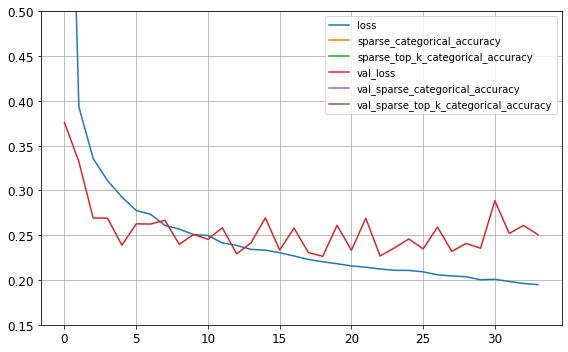

Saving figure model_1_11_learning_curves_plot_accuracy


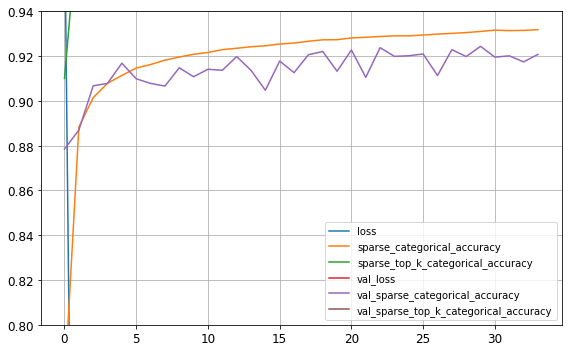

In [300]:
pd.DataFrame(history_1_11.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.15, 0.5)
save_fig("model_1_11_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_11.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 0.94)
save_fig("model_1_11_learning_curves_plot_accuracy")
plt.show()

#### 1.12 Training the Balanced Model for Combination of (Cropped And Resized NIST19 (OpenCV) + Padded T-H-E)

In [267]:
X_train = np.load("./SplittedDatasets/5/X_train_5.npy")
y_train = np.load("./SplittedDatasets/5/y_train_5.npy")

In [268]:
from sklearn.utils import class_weight
y_train_class_weights = y_train.reshape(-1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train_class_weights)

In [270]:
class_weights = {i : class_weights[i] for i in range(class_weights.shape[0])}

In [272]:
baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [273]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [275]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_1_12.h5", save_best_only=True)

In [276]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_12"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [278]:
model_1_12_t0 = time.time()
history_1_12 = baseline_model.fit(X_train, y_train, class_weight=class_weights, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_12_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 374s 22ms/step - loss: 0.2329 - sparse_categorical_accuracy: 0.9217 - sparse_top_k_categorical_accuracy: 0.9945 - val_loss: 0.2413 - val_sparse_categorical_accuracy: 0.9177 - val_sparse_top_k_categorical_accuracy: 0.9926
Epoch 2/100
16688/16688 [==============================] - 379s 23ms/step - loss: 0.2067 - sparse_categorical_accuracy: 0.9246 - sparse_top_k_categorical_accuracy: 0.9948 - val_loss: 0.2501 - val_sparse_categorical_accuracy: 0.9190 - val_sparse_top_k_categorical_accuracy: 0.9929
Epoch 3/100
16688/16688 [==============================] - 380s 23ms/step - loss: 0.1983 - sparse_categorical_accuracy: 0.9256 - sparse_top_k_categorical_accuracy: 0.9951 - val_loss: 0.2261 - val_sparse_categorical_accuracy: 0.9213 - val_sparse_top_k_categorical_accuracy: 0.9935
Epoch 4/100
16688/16688 [==============================] - 383s 23ms/step - loss: 0.1893 - sparse_categorical_accuracy: 0.9270 - sparse_top_k_categorical_accura

In [279]:
print("Training took {:.2f}s for all Epochs".format(model_1_12_t1 - model_1_12_t0))

Training took 8361.92s for all Epochs


In [280]:
history_1_12.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [281]:
print("Best Training Accuracy: ", round(history_1_12.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_12.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_12.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_12.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_12.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_12.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.92852
Best Training Loss:  0.1802
Best Training Top k Accuracy:  0.99558
Best Validation Accuracy:  0.92496
Best Validation Loss:  0.22159
Best Validation Top k Accuracy:  0.99348


In [282]:
baseline_model.save("./Model_Checkpoints/baseline_model_1_12")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_12\assets


Saving figure model_1_12_learning_curves_plot_loss


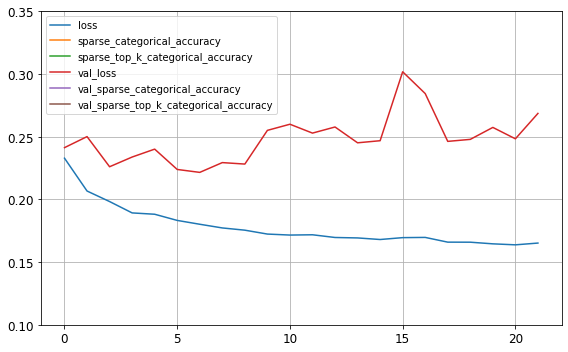

Saving figure model_1_12_learning_curves_plot_accuracy


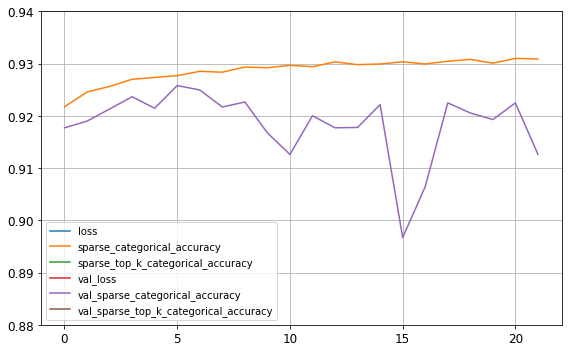

In [297]:
pd.DataFrame(history_1_12.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.1, 0.35)
save_fig("model_1_12_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_12.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.88, 0.94)
save_fig("model_1_12_learning_curves_plot_accuracy")
plt.show()

#### 1.13 Training the Balanced Model for Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E + Padded T-H-E)

In [284]:
X_train = np.load("./SplittedDatasets/8/X_train_8.npy")
y_train = np.load("./SplittedDatasets/8/y_train_8.npy")

In [285]:
from sklearn.utils import class_weight
y_train_class_weights = y_train.reshape(-1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train_class_weights)

In [286]:
class_weights = {i : class_weights[i] for i in range(class_weights.shape[0])}

In [287]:
baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [288]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [289]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_1_13.h5", save_best_only=True)

In [290]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_13"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [291]:
model_1_13_t0 = time.time()
history_1_13 = baseline_model.fit(X_train, y_train, class_weight=class_weights, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_13_t1 = time.time()

Epoch 1/100
16913/16913 [==============================] - 381s 22ms/step - loss: 0.2522 - sparse_categorical_accuracy: 0.9213 - sparse_top_k_categorical_accuracy: 0.9937 - val_loss: 0.2144 - val_sparse_categorical_accuracy: 0.9220 - val_sparse_top_k_categorical_accuracy: 0.9941
Epoch 2/100
16913/16913 [==============================] - 381s 23ms/step - loss: 0.2185 - sparse_categorical_accuracy: 0.9240 - sparse_top_k_categorical_accuracy: 0.9949 - val_loss: 0.1975 - val_sparse_categorical_accuracy: 0.9272 - val_sparse_top_k_categorical_accuracy: 0.9952
Epoch 3/100
16913/16913 [==============================] - 380s 22ms/step - loss: 0.2129 - sparse_categorical_accuracy: 0.9249 - sparse_top_k_categorical_accuracy: 0.9949 - val_loss: 0.2060 - val_sparse_categorical_accuracy: 0.9245 - val_sparse_top_k_categorical_accuracy: 0.9949
Epoch 4/100
16913/16913 [==============================] - 382s 23ms/step - loss: 0.2089 - sparse_categorical_accuracy: 0.9253 - sparse_top_k_categorical_accura

In [292]:
print("Training took {:.2f}s for all Epochs".format(model_1_13_t1 - model_1_13_t0 - 11646.0))

Training took 7992.61s for all Epochs


In [293]:
history_1_13.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [294]:
print("Best Training Accuracy: ", round(history_1_13.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_13.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_13.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_13.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_13.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_13.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.92642
Best Training Loss:  0.20213
Best Training Top k Accuracy:  0.9953
Best Validation Accuracy:  0.93241
Best Validation Loss:  0.19181
Best Validation Top k Accuracy:  0.99565


In [295]:
baseline_model.save("./Model_Checkpoints/baseline_model_1_13")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_13\assets


Saving figure model_1_13_learning_curves_plot_loss


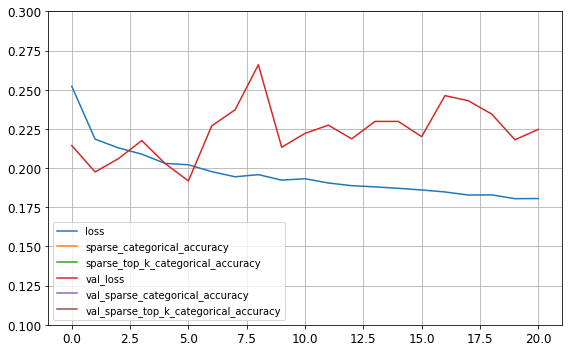

Saving figure model_1_13_learning_curves_plot_accuracy


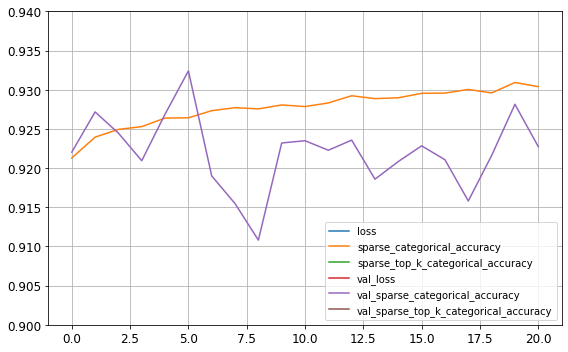

In [298]:
pd.DataFrame(history_1_13.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.1, 0.3)
save_fig("model_1_13_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_13.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.9, 0.94)
save_fig("model_1_13_learning_curves_plot_accuracy")
plt.show()